In [1]:
import os
os.chdir('../')

In [2]:
import cv2
from IPython.display import clear_output
import torch
from torch.functional import F
import numpy as np
from time import sleep
from einops.layers.torch import Rearrange
from torchvision.transforms import Compose

from src.opts.opts import parser
from src.models.model import VideoModel
from src.dataset.video_dataset import VideoDataset, prepare_clips_data
from src.dataset.prepare_labels_mapping import id_to_action_name
from src.dataset.video_transforms import (
    GroupMultiScaleCrop,
    IdentityTransform,
    GroupScale, 
    GroupCenterCrop, 
    GroupRandomCrop,
    Stack, 
    ToTorchFormatTensor, 
    GroupNormalize, 
    GroupRandomHorizontalFlip
)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

In [3]:
# Load config and adjust for local run
args = parser.parse_args([])
args.num_segments = 8
args.base_model = "InceptionV3" 
args.fusion_mode = "GSF" 
args.__dict__

{'holoassist_dir': '/Users/artemmerinov/data/holoassist',
 'raw_annotation_file': '/Users/artemmerinov/data/holoassist/data-annotation-trainval-v1_1.json',
 'split_dir': '/Users/artemmerinov/data/holoassist/data-splits-v1',
 'fine_grained_actions_map_file': '/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt',
 'dataset_name': 'holoassist',
 'fusion_mode': 'GSF',
 'base_model': 'InceptionV3',
 'num_segments': 8,
 'dropout': 0.5,
 'resume': None,
 'start_epoch': 0,
 'num_epochs': 10,
 'batch_size': 16,
 'lr': 0.01,
 'momentum': 0.9,
 'weight_decay': 0.0005,
 'clip_gradient': None,
 'checkpoint_interval': 3,
 'runs_path': 'runs/',
 'num_workers': 4}

In [4]:
if args.dataset_name == 'holoassist':
    num_classes = 1887 # actions
else:
    raise NotImplementedError()

id_to_action_name_dict = id_to_action_name(
    fine_grained_actions_map_file="/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt"
)

# Define model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VideoModel(
    num_classes=num_classes, 
    num_segments=args.num_segments, 
    base_model=args.base_model,
    fusion_mode=args.fusion_mode,
    dropout=args.dropout,
    verbose=False
).to(device)

crop_size = model.crop_size
scale_size = model.scale_size
input_mean = model.input_mean
input_std = model.input_std
model = torch.nn.DataParallel(model).to(device)

=> Using GSF fusion
No. of GSF modules = 11


# Load state

In [6]:
checkpoint = torch.load(
    f='checkpoints/holoassist_InceptionV3_GSF_06.pth', 
    map_location=torch.device(device)
)

# state_dict = {key[7:] if key.startswith('module.') else key: value for key, value in checkpoint['model_state_dict'].items()}
state_dict = checkpoint['model_state_dict']

In [7]:
# model.load_state_dict(state_dict=state_dict)
model.load_state_dict(state_dict=state_dict)
model.eval();

# Dataset

In [73]:
clip_path_to_video_arr, clip_start_arr, clip_end_arr, clip_action_id_arr = prepare_clips_data(
    raw_annotation_file=args.raw_annotation_file,
    holoassist_dir=args.holoassist_dir, 
    split_dir=args.split_dir,
    fine_grained_actions_map_file=args.fine_grained_actions_map_file,
    mode="validation",
)

transform = Compose([
    GroupMultiScaleCrop(input_size=crop_size, scales=[1, .875]),
    Stack(),
    ToTorchFormatTensor(div=(args.base_model not in ['BNInception'])),
    GroupNormalize(mean=input_mean, std=input_std),
])

tr_dataset = VideoDataset(
    clip_path_to_video_arr=clip_path_to_video_arr,
    clip_start_arr=clip_start_arr,
    clip_end_arr=clip_end_arr,
    clip_action_id_arr=clip_action_id_arr,
    num_segments=args.num_segments,
    transform=transform,
    mode="validation"
)

There are 213 videos in the list There are 13 videos as video files There are 206 videos that present in the list but are missing as videos.
Number of clips: 470 for mode validation


In [74]:
len(tr_dataset)

470

In [80]:
# 177 -- 181
data, label = tr_dataset[453]
print(id_to_action_name_dict[label])

c_t, h, w = data.size()
preds = F.softmax(model(data.view(1, c_t, h, w)), dim=1)
_, largest_ids = torch.topk(preds, k=10, dim=1, largest=True, sorted=True)
print([id_to_action_name_dict[i.item()] for i in largest_ids[0]])

approach-hex_socket_head
['withdraw-allen_wrench', 'approach-hex_socket_head', 'grab-hex_socket_head', 'disassemble-hex_socket_head', 'withdraw-hex_socket_head', 'grab-allen_wrench', 'rotate-allen_wrench', 'align-circle', 'place-hex_socket_head', 'insert-hex_socket_head']


In [81]:
preds.shape

torch.Size([1, 1887])

In [82]:
rearranged_data = Rearrange("(t c) h w -> t h w c", t=args.num_segments, c=3, h=299, w=299)(data)
print(rearranged_data.shape)

# choose first frame
img = rearranged_data[0]
img = img * np.array(input_std) + np.array(input_mean)

# plt.imshow(img);
# plt.axis('off');

torch.Size([8, 299, 299, 3])


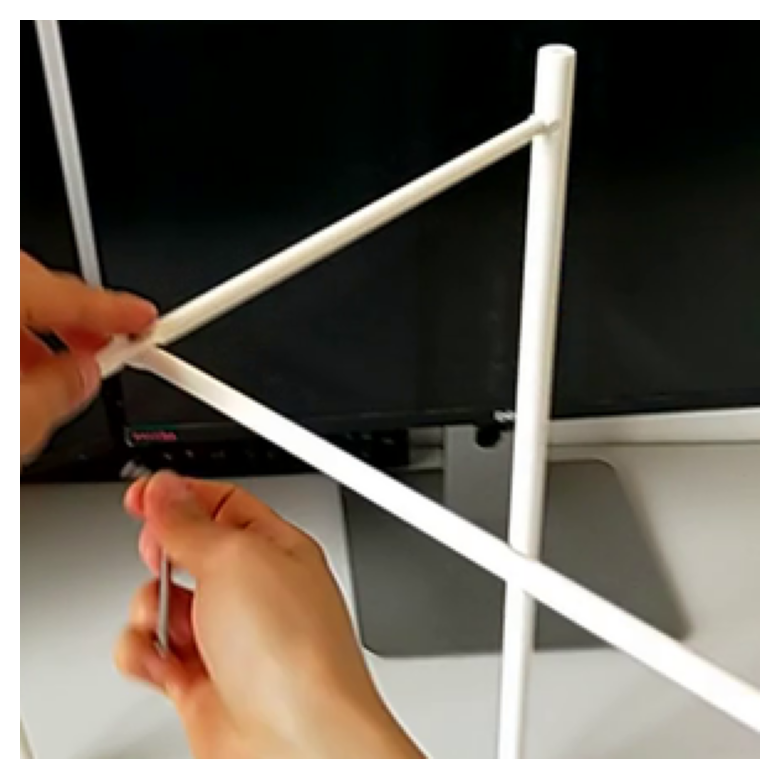

In [83]:
plt.figure()
for i in range(len(rearranged_data)):
    frame = rearranged_data[i]
    frame = frame * np.array(input_std) + np.array(input_mean)
    plt.imshow(frame)
    plt.axis('off')  
    plt.show()
    sleep(0.1)
    clear_output(wait=True)

# CAM

In [84]:
# !pip install grad-cam

In [85]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [86]:
target_layers = [model.module.base_model.mixed_10_tower_2_conv]
# target_layers = [model.base_model.mixed_10_tower_2_conv_Conv2D]

# cam = GradCAM(model=model, target_layers=target_layers)
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(label+1)]
grayscale_cams = cam(input_tensor=data.view(1, c_t, h, w), targets=targets)
grayscale_cams.shape

(8, 299, 299)

In [87]:
images = []
cam_images = []
for segment in range(args.num_segments):

    img = rearranged_data[segment]
    img = img * np.array(input_std) + np.array(input_mean) # inverse norm
    # img = img[:, :, [2, 1, 0]] # bgr -> rgb
    # img = img / 255 # [0...255] -> [0...1]

    cam_image = show_cam_on_image(
        img=np.array(img), 
        mask=grayscale_cams[segment], 
        use_rgb=True, 
        image_weight=0.5
    )
    images.append(img)
    cam_images.append(cam_image)

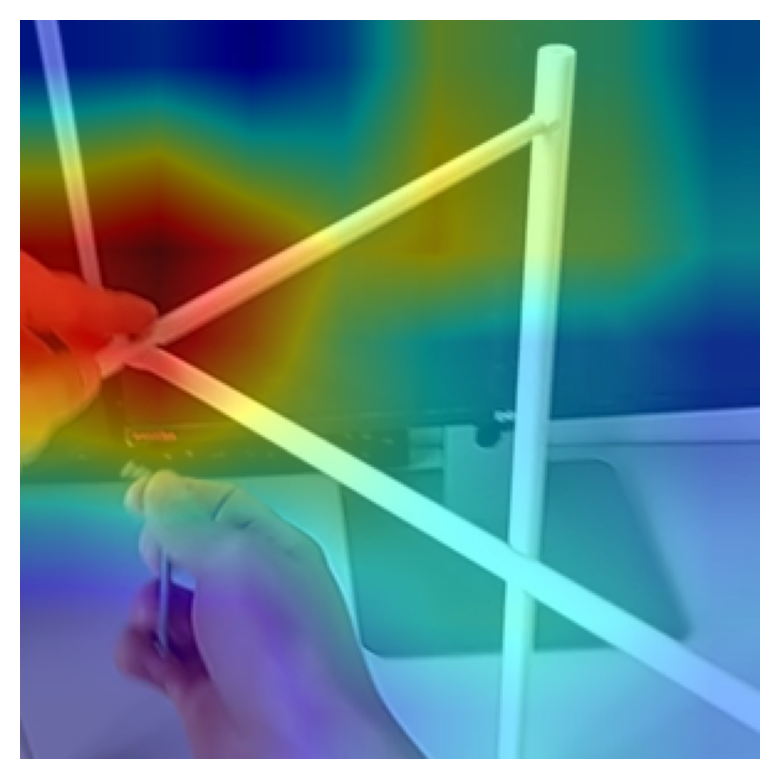

In [88]:
plt.figure()
for i in range(len(cam_images)):
    plt.imshow(cam_images[i])
    plt.axis('off')  
    plt.show()
    sleep(0.01)
    clear_output(wait=True)